**FrozenLake Problem**

In [ ]:
#Import any necessary libraries such as "gymnasium" for the reinforcement learning model
import gymnasium as gym
import numpy as np
import time
from typing import Tuple
import matplotlib.pyplot as plt

In [ ]:
# Creating the environment for the model by setting the grid size
# Allowing randomness from the slippery funnction
# Set number of possible actions the agent can take
#is_slippery can be set to false
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode="ansi")

n_states = env.observation_space.n
n_actions = env.action_space.n

print("Action space:", env.action_space)            # Discrete(4)
print("Observation space:", env.observation_space)  # Discrete(16)


Action space: Discrete(4)
Observation space: Discrete(16)


In [ ]:
#Demonstration of the agent before it is trained
#After program is ran the most likely outcome is "0 rewards"
# No learning policy was included in this trial
# Shows how an agent will almost never obtain a reward in the slipper environment
def play_random_episode(env, sleep: float = 0.2):
    state, info = env.reset()
    done = False
    total_reward = 0
    print("\nRandom policy episode (for illustration):")
    print(env.render())
    while not done:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        print(env.render())
        time.sleep(sleep)
        state = next_state
    print(f"Finished. Reward: {total_reward}")

play_random_episode(env)


Random policy episode (for illustration):

SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Up)
SFFF
FHFH
FFFH
HFFG

Finished. Reward: 0


In [ ]:
# Hyperparameters that can be changed for the model depending on the goals
#Q-table initializaion for the agent
#The parameter can control such things as how dfast the agent learns and the random actions it will take

Q = np.zeros((n_states, n_actions), dtype=np.float32)


alpha = 0.1         # Learning rate
gamma = 0.99        # Discount factor
epsilon = 1.0       # Starting exploration rate
epsilon_min = 0.01
epsilon_decay = 0.9995    # Decay per episode
episodes = 30000          # Episodes parameter
max_steps_per_episode = 200


rng = np.random.default_rng(42)

def epsilon_greedy_action(state: int) -> int:
    if rng.random() < epsilon:
        return env.action_space.sample()
    return int(np.argmax(Q[state]))


In [ ]:
# Training loop where the agent will run on the frozen lake environment multiple times
#Q-table will be constantly updated after each step to teach the agent how to make it to the goal
#This function will also record the episode, epsilon value, and rewards that the agent achieves

def train():
    global epsilon
    rewards_history = []
    epsilon_history = []  # Track epsilon per episode (value used during the episode)

    for ep in range(episodes):
        state, info = env.reset()
        total_reward = 0

        # record epsilon used this episode
        epsilon_history.append(epsilon)

        for t in range(max_steps_per_episode):
            action = epsilon_greedy_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Q-learning update
            best_next = np.max(Q[next_state])
            td_target = reward + gamma * best_next * (0 if done else 1)
            Q[state, action] = (1 - alpha) * Q[state, action] + alpha * td_target

            state = next_state
            total_reward += reward
            if done:
                break

        # epsilon decay
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_history.append(total_reward)

        if (ep + 1) % 5000 == 0:
            avg_last_5k = np.mean(rewards_history[-5000:])
            print(f"Episode {ep+1}/{episodes} | epsilon={epsilon:.3f} | "
                  f"Avg reward (last 5k): {avg_last_5k:.3f}")
    return rewards_history, epsilon_history

print("\n=== Training Q-learning agent on FrozenLake-v1 (slippery) ===")
train_rewards, epsilon_history = train()



=== Training Q-learning agent on FrozenLake-v1 (slippery) ===
Episode 5000/30000 | epsilon=0.082 | Avg reward (last 5k): 0.180
Episode 10000/30000 | epsilon=0.010 | Avg reward (last 5k): 0.591
Episode 15000/30000 | epsilon=0.010 | Avg reward (last 5k): 0.674
Episode 20000/30000 | epsilon=0.010 | Avg reward (last 5k): 0.668
Episode 25000/30000 | epsilon=0.010 | Avg reward (last 5k): 0.651
Episode 30000/30000 | epsilon=0.010 | Avg reward (last 5k): 0.672


In [ ]:
# This code  visualizes the strategy which the agent created to achieve the goal
#Simply explains the agents Q-table actions and policy it has learned
policy = np.argmax(Q, axis=1)  # shape: (n_states,)

# Possible actions the agent can take, 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP
action_to_arrow = {0: "←", 1: "↓", 2: "→", 3: "↑"}
action_to_name  = {0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP"}

def decode_map(env) -> np.ndarray:
    desc = env.unwrapped.desc  # bytes array of shape (nrow, ncol)
    grid = np.array([[c.decode("utf-8") for c in row] for row in desc])
    return grid

def print_policy_grid(env, policy):
    grid = decode_map(env)
    nrow, ncol = grid.shape
    out = []
    for s in range(n_states):
        r, c = divmod(s, ncol)
        cell = grid[r, c]
        if cell in ("S", "H", "G"):
            out.append(cell)
        else:
            out.append(action_to_arrow[int(policy[s])])
    print("\nLearned greedy policy (arrows). S=start, G=goal, H=hole:")
    for r in range(nrow):
        row_str = " ".join(out[r*ncol:(r+1)*ncol])
        print(row_str)

print_policy_grid(env, policy)



Learned greedy policy (arrows). S=start, G=goal, H=hole:
S ↑ ↑ ↑
← H → H
↑ ↓ ← H
H → ↓ G


In [ ]:
# Testing will now begin for the agent after it has learned a policy to reach the goal
#This showcases how well the model will run after training on the frozen lake
#Success rate and average steps will be recorded to understand how effective the previous training was

def run_greedy_episode(env, render: bool = False, sleep: float = 0.1) -> Tuple[float, int]:
    state, info = env.reset()
    total_reward, steps = 0.0, 0
    done = False

    while not done and steps < max_steps_per_episode:
        action = int(np.argmax(Q[state]))
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        steps += 1

        if render:
            print(env.render())
            time.sleep(sleep)

        state = next_state
    return total_reward, steps

N_EVAL = 100
successes, total_steps = 0, 0

for _ in range(N_EVAL):
    r, steps = run_greedy_episode(env, render=False)
    successes += int(r > 0.0)
    total_steps += steps

success_rate = 100.0 * successes / N_EVAL
avg_steps = total_steps / N_EVAL

print(f"\n=== Evaluation over {N_EVAL} episodes ===")
print(f"Successes: {successes}/{N_EVAL} ({success_rate:.1f}%)")
print(f"Average steps per episode: {avg_steps:.1f}")



=== Evaluation over 100 episodes ===
Successes: 73/100 (73.0%)
Average steps per episode: 46.2


In [ ]:
# This code will visualize the steps the agent takes and how it is learning from mistakes to reach the goal
#After the code is ran it can be shown that it took the agent 29 steps to either receive a reward or not

def run_and_show_episode(env, Q, sleep: float = 0.5, max_steps: int = 100):
    """Run one greedy episode using the learned Q-table and show steps."""
    state, info = env.reset()
    done = False
    total_reward, steps = 0, 0

    print("\nAgent run (greedy policy):")
    print(env.render())  # initial map/frame

    while not done and steps < max_steps:
        action = int(np.argmax(Q[state]))
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        steps += 1

        print(f"\nStep {steps}: Action = {action} ({action_to_name[action]})")
        print(env.render())
        time.sleep(sleep)

        state = next_state

    print(f"\nEpisode finished after {steps} steps. "
          f"Reward = {total_reward} ({'SUCCESS' if total_reward > 0 else 'FAIL'})")

# Run once to visualize:
run_and_show_episode(env, Q, sleep=0.4, max_steps=100)



Agent run (greedy policy):

SFFF
FHFH
FFFH
HFFG


Step 1: Action = 0 (LEFT)
  (Left)
SFFF
FHFH
FFFH
HFFG


Step 2: Action = 0 (LEFT)
  (Left)
SFFF
FHFH
FFFH
HFFG


Step 3: Action = 0 (LEFT)
  (Left)
SFFF
FHFH
FFFH
HFFG


Step 4: Action = 0 (LEFT)
  (Left)
SFFF
FHFH
FFFH
HFFG


Step 5: Action = 0 (LEFT)
  (Left)
SFFF
FHFH
FFFH
HFFG


Step 6: Action = 0 (LEFT)
  (Left)
SFFF
FHFH
FFFH
HFFG


Step 7: Action = 3 (UP)
  (Up)
SFFF
FHFH
FFFH
HFFG


Step 8: Action = 1 (DOWN)
  (Down)
SFFF
FHFH
FFFH
HFFG


Step 9: Action = 0 (LEFT)
  (Left)
SFFF
FHFH
FFFH
HFFG


Step 10: Action = 1 (DOWN)
  (Down)
SFFF
FHFH
FFFH
HFFG


Step 11: Action = 3 (UP)
  (Up)
SFFF
FHFH
FFFH
HFFG


Step 12: Action = 1 (DOWN)
  (Down)
SFFF
FHFH
FFFH
HFFG


Step 13: Action = 2 (RIGHT)
  (Right)
SFFF
FHFH
FFFH
HFFG


Step 14: Action = 1 (DOWN)
  (Down)
SFFF
FHFH
FFFH
HFFG


Step 15: Action = 2 (RIGHT)
  (Right)
SFFF
FHFH
FFFH
HFFG


Step 16: Action = 1 (DOWN)
  (Down)
SFFF
FHFH
FFFH
HFFG


Step 17: Action = 3 (UP)
  (Up)
SF

In [ ]:
#Visualization plots that can help the project manager understand how well the model is running after it is trained.
#Will visualize "Episode reward trend" and "Epsilon decay"
def moving_avg(x, w):
    x = np.asarray(x, dtype=float)
    if w <= 1 or w > len(x):
        return x
    return np.convolve(x, np.ones(w)/w, mode='valid')

def plot_training_curves(rewards, eps_history, window=500):
    # Figure 1: Reward (raw + moving average)
    plt.figure(figsize=(9,4))
    plt.plot(rewards, alpha=0.35, label="Reward (raw)")
    ma_r = moving_avg(rewards, window)
    plt.plot(np.arange(len(ma_r)), ma_r, label=f"Reward (MA {window})")
    plt.title("Episode Reward Trend")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Figure 2: Epsilon decay per episode
    if eps_history is not None and len(eps_history) == len(rewards):
        plt.figure(figsize=(9,4))
        plt.plot(eps_history, label="Epsilon")
        plt.title("Epsilon Decay over Episodes")
        plt.xlabel("Episode")
        plt.ylabel("Exploration Rate (ε)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Figure 3: Combined overlay — Reward (MA) vs Epsilon
        if len(ma_r) > 0:
            fig, ax1 = plt.subplots(figsize=(9,4))
            ax1.plot(np.arange(len(ma_r)), ma_r, label=f"Reward (MA {window})")
            ax1.set_xlabel("Episode")
            ax1.set_ylabel("Reward (MA)")
            ax1.set_title("Reward (Moving Avg) vs Epsilon Decay")

            ax2 = ax1.twinx()
            # Align lengths by trimming epsilon to MA length
            eps_trim = eps_history[-len(ma_r):] if len(eps_history) >= len(ma_r) else eps_history
            x_eps = np.arange(len(eps_trim))
            ax2.plot(x_eps, eps_trim, label="Epsilon", linestyle="--")
            ax2.set_ylabel("Exploration Rate (ε)")

            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
            fig.tight_layout()
            plt.show()


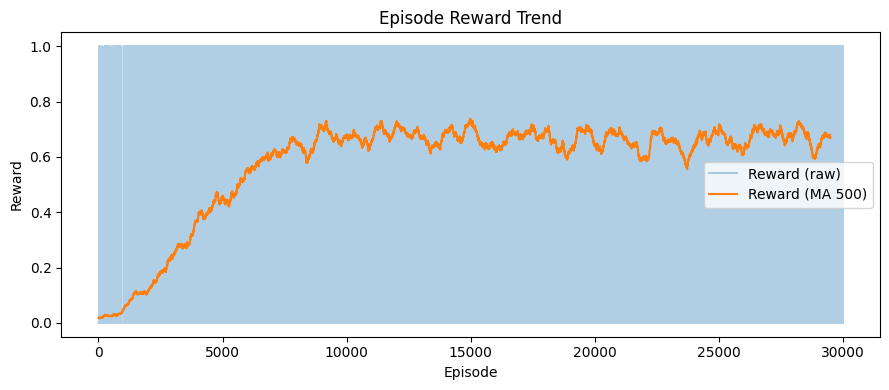

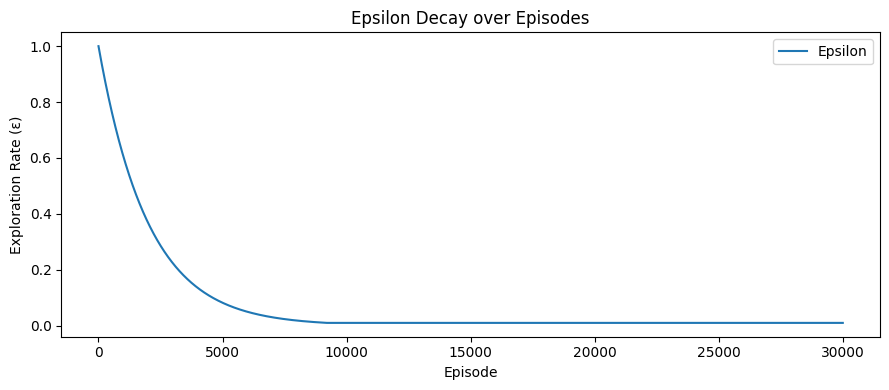

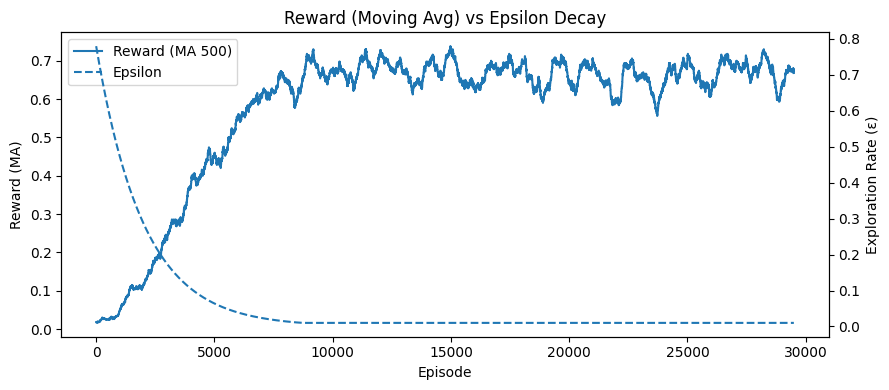

In [ ]:
plot_training_curves(train_rewards, epsilon_history, window=500)


Hello Boss,

The model used here is to help explain the use of the reinforcement learning algorithm. Reinforcement learning is a algorithm that can self learn with little human involvement. The algorithm is able to obtain a goal by following conditions or rules that it discovers based on the goal set by the user. The agent will thus learn a policy in which can be tested to see how well the agent learned from the training set. This algorithim sets rewards and penalties for the agent so it can figure out the problem and solve it without any help.

Within this model created above, it can be shown that the agent is rather successful in finding out the goal of the environment set. Due to certain factors like the slippery function, it can cause the agent to end up taking random actions such as it may want to go left, but "slips" down instead. After the initial set up is finished, the model will be trained using a q-table to help find the most optimal route for the goal. After training has been completed, the model will then be tested on the frozen lake environment only using the policy it has learned from the training. After training is completed, this model was able to achieve a 73% success rate over 100 epsiodes with an average step of 46.2.

**Waiter** **Agent Reinforcement Learning Model**

In [ ]:
#Import any necessary libraries such as "gymnasium" for the reinforcement learning model
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt


In [ ]:
#Custom gymansium that sets the environment to replicate a restauraunt environment for the agent
#Simulates how the agent will deal with restauraunt operations such as taking orders, cleaning, serving, tending to customers and tables
#Parameters such as the max tables and que will be set for the environment in this block of code
class RestaurantWaiterEnv(gym.Env):
    """
    State = (waiting_queue, free_tables, seated_waiting_food, ready_orders, dirty_tables)
    Actions:
      0: Idle
      1: Seat & Take Order     (if waiting_queue > 0 and free_tables > 0)
      2: Serve Ready Order     (if ready_orders > 0)
      3: Clean Table           (if dirty_tables > 0)
    """
    metadata = {"render_modes": ["ansi"]}

    def __init__(
        self,
        max_tables=5,
        max_queue=10,
        max_kitchen_backlog=10,
        episode_len=200,
        p_arrival=0.35,
        cook_time_min=2,
        cook_time_max=5,
        patience_min=6,
        patience_max=12,
        seed=None,
        render_mode=None
    ):
        super().__init__()
        self.rng = np.random.default_rng(seed)

        # Parameters
        self.max_tables = max_tables
        self.max_queue = max_queue
        self.max_kitchen_backlog = max_kitchen_backlog
        self.episode_len = episode_len
        self.p_arrival = p_arrival
        self.cook_time_min = cook_time_min
        self.cook_time_max = cook_time_max
        self.patience_min = patience_min
        self.patience_max = patience_max

        # Observation space (discrete counts)
        low  = np.array([0, 0, 0, 0, 0], dtype=np.int32)
        high = np.array([self.max_queue, self.max_tables, self.max_tables,
                         self.max_tables, self.max_tables], dtype=np.int32)
        self.observation_space = spaces.Box(low=low, high=high, shape=(5,), dtype=np.int32)

        # Actions
        self.action_space = spaces.Discrete(4)

        # Internal trackers
        self.waiting_patience = deque()  # patience list for each customer in queue
        self.kitchen_orders = deque()    # remaining cook times for each active order

        self.free_tables = self.max_tables
        self.seated_waiting_food = 0
        self.ready_orders = 0
        self.dirty_tables = 0
        self.waiting_queue = 0

        self.t = 0
        self.total_served = 0
        self.total_abandoned = 0

        self.render_mode = render_mode
        self._last_info = {}

    def seed(self, seed=None):
        self.rng = np.random.default_rng(seed)

    def _bounded_inc(self, val, maxv, inc=1): return min(val + inc, maxv)
    def _bounded_dec(self, val, dec=1): return max(val - dec, 0)

    def _state(self):
        return np.array([
            self.waiting_queue,
            self.free_tables,
            self.seated_waiting_food,
            self.ready_orders,
            self.dirty_tables
        ], dtype=np.int32)

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.seed(seed)
        self.waiting_patience.clear()
        self.kitchen_orders.clear()
        self.free_tables = self.max_tables
        self.seated_waiting_food = 0
        self.ready_orders = 0
        self.dirty_tables = 0
        self.waiting_queue = 0
        self.t = 0
        self.total_served = 0
        self.total_abandoned = 0
        return self._state(), {}

    def step(self, action):
        """
        Order:
        1) Arrivals
        2) Apply action
        3) Kitchen progresses -> ready orders
        4) Patience decay & abandon
        5) Rewards & termination
        """
        reward = 0.0
        info = {}
        done = False
        truncated = False

        # (1) Arrivals
        if self.rng.random() < self.p_arrival and self.waiting_queue < self.max_queue:
            self.waiting_queue += 1
            pat = int(self.rng.integers(self.patience_min, self.patience_max + 1))
            self.waiting_patience.append(pat)

        # (2) Apply action
        if action == 1:
            if self.waiting_queue > 0 and self.free_tables > 0:
                self.waiting_queue -= 1
                self.free_tables -= 1
                self.seated_waiting_food += 1
                if self.waiting_patience:
                    self.waiting_patience.popleft()
                if len(self.kitchen_orders) < self.max_kitchen_backlog:
                    cook_time = int(self.rng.integers(self.cook_time_min, self.cook_time_max + 1))
                    self.kitchen_orders.append(cook_time)
                    reward += 1.0
        elif action == 2:
            if self.ready_orders > 0:
                self.ready_orders -= 1
                self.seated_waiting_food = self._bounded_dec(self.seated_waiting_food, 1)
                self.dirty_tables = self._bounded_inc(self.dirty_tables, self.max_tables, 1)
                reward += 5.0
                self.total_served += 1
        elif action == 3:
            if self.dirty_tables > 0:
                self.dirty_tables -= 1
                self.free_tables = self._bounded_inc(self.free_tables, self.max_tables, 1)
                reward += 1.0
        # action == 0 -> idle

        # (3) Kitchen progress
        finished = 0
        if self.kitchen_orders:
            for i in range(len(self.kitchen_orders)):
                self.kitchen_orders[i] -= 1
            while self.kitchen_orders and self.kitchen_orders[0] <= 0:
                self.kitchen_orders.popleft()
                finished += 1
        if finished > 0:
            can_ready = min(finished, self.seated_waiting_food - self.ready_orders)
            if can_ready > 0:
                self.ready_orders = min(self.ready_orders + can_ready, self.max_tables)

        # (4) Patience decay & abandon
        abandons = 0
        if self.waiting_queue > 0 and self.waiting_patience:
            self.waiting_patience = deque([p - 1 for p in self.waiting_patience])
            while self.waiting_patience and self.waiting_patience[0] <= 0 and self.waiting_queue > 0:
                self.waiting_patience.popleft()
                self.waiting_queue -= 1
                abandons += 1
            if abandons > 0:
                self.total_abandoned += abandons
                reward -= 2.0 * abandons

        # (5) Shaping penalties
        reward -= 0.1 * self.waiting_queue
        reward -= 0.2 * self.seated_waiting_food
        reward -= 0.5 * self.dirty_tables
        reward -= 0.01

        self.t += 1
        if self.t >= self.episode_len:
            done = True

        info.update({
            "served": self.total_served,
            "abandoned": self.total_abandoned,
            "finished_now": finished,
            "abandons_now": abandons
        })
        self._last_info = info
        return self._state(), float(reward), done, truncated, info

    def render(self):
        s = (
            f"t={self.t} | "
            f"Queue={self.waiting_queue} | Free={self.free_tables} | "
            f"SeatedWaitingFood={self.seated_waiting_food} | Ready={self.ready_orders} | "
            f"Dirty={self.dirty_tables} | Served={self.total_served} | "
            f"Abandoned={self.total_abandoned}"
        )
        return s


In [ ]:
# Q-table is created and intitialized for the agent to learn the best policy for the environment set
# The state will be mapped on the Q-table and will be constantly updated for the agent to learn the best possible route
def encode_state(state, env):
    W = env.max_queue + 1
    F = env.max_tables + 1
    S = env.max_tables + 1
    R = env.max_tables + 1
    D = env.max_tables + 1
    w, f, s, r, d = state.astype(int)
    idx = (((w * F + f) * S + s) * R + r) * D + d
    return idx

def make_q_table(env):
    W = env.max_queue + 1
    F = env.max_tables + 1
    S = env.max_tables + 1
    R = env.max_tables + 1
    D = env.max_tables + 1
    n_states = W * F * S * R * D
    n_actions = env.action_space.n
    return np.zeros((n_states, n_actions), dtype=np.float32)

def epsilon_greedy(q_row, epsilon):
    if random.random() < epsilon:
        return random.randrange(len(q_row))
    return int(np.argmax(q_row))


In [ ]:
# Training loop that will teach the agent using the q-table
#Records the episodes and the averages of rewards, people served, and the amount of people who abandoned waiting for the agent
#Parameters can be set within this code such as the amount of episodes and the learning rate
#Trains the agent to learn the best policy for the environment
def train_q_learning(
    env,
    episodes=5000,
    alpha=0.15,
    gamma=0.98,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay_ratio=0.85,
    verbose_every=500
):
    q = make_q_table(env)
    # Track epsilon each episode (recorded during learning)
    metrics = {"ep_reward": [], "ep_served": [], "ep_abandoned": [], "epsilon": []}

    decay_episodes = int(episodes * epsilon_decay_ratio)
    def get_epsilon(ep):
        if ep < decay_episodes:
            return epsilon_start - (epsilon_start - epsilon_end) * (ep / decay_episodes)
        return epsilon_end

    for ep in range(1, episodes + 1):
        state, _ = env.reset()
        s_idx = encode_state(state, env)
        done = False
        total_r = 0.0
        served0 = 0
        abandoned0 = 0
        epsilon = get_epsilon(ep)

        while not done:
            action = epsilon_greedy(q[s_idx], epsilon)
            next_state, reward, done, truncated, info = env.step(action)
            ns_idx = encode_state(next_state, env)

            best_next = np.max(q[ns_idx])
            q[s_idx, action] += alpha * (reward - q[s_idx, action] + gamma * best_next)

            s_idx = ns_idx
            total_r += reward
            served0 = info.get("served", served0)
            abandoned0 = info.get("abandoned", abandoned0)

        # Record metrics including the epsilon used during this episode
        metrics["ep_reward"].append(total_r)
        metrics["ep_served"].append(served0)
        metrics["ep_abandoned"].append(abandoned0)
        metrics["epsilon"].append(epsilon)

        if verbose_every and (ep % verbose_every == 0):
            avgR = np.mean(metrics["ep_reward"][-verbose_every:])
            avgS = np.mean(metrics["ep_served"][-verbose_every:])
            avgA = np.mean(metrics["ep_abandoned"][-verbose_every:])
            print(f"Episode {ep:5d} | avg_reward={avgR:7.2f} | avg_served={avgS:5.2f} | avg_abandoned={avgA:5.2f}")

    return q, metrics


In [ ]:
#Model will now be tested after previously trained using the Q-table
#The learned policy will help the manager understand how well the model was training
def evaluate_policy(env, q, episodes=20, render=False):
    total_r = 0.0
    total_served = 0
    total_abandoned = 0
    for ep in range(episodes):
        s, _ = env.reset()
        done = False
        ep_r = 0.0
        served0 = 0
        abandoned0 = 0
        while not done:
            s_idx = encode_state(s, env)
            a = int(np.argmax(q[s_idx]))
            s, r, done, truncated, info = env.step(a)
            ep_r += r
            if render and (ep == episodes - 1):
                print(env.render())
            served0 = info.get("served", served0)
            abandoned0 = info.get("abandoned", abandoned0)
        total_r += ep_r
        total_served += served0
        total_abandoned += abandoned0
    print(f"[EVAL] episodes={episodes} | avg_reward={total_r / episodes:.2f} | "
          f"avg_served={total_served / episodes:.2f} | avg_abandoned={total_abandoned / episodes:.2f}")


In [ ]:
#Visualization plots that can help the project manager understand how well the model is running after it is trained.
#Will visualize "Episode reward trend" and "Epsilon decay"
def moving_avg(x, w):
    x = np.asarray(x, dtype=float)
    if w <= 1 or w > len(x):
        return x
    return np.convolve(x, np.ones(w)/w, mode='valid')

def plot_training(history, window=100):
    """Plot reward trend, served vs abandoned, success rate, epsilon decay, and a combined overlay."""
    rewards = history["ep_reward"]
    served = history["ep_served"]
    abandoned = history["ep_abandoned"]
    eps_vals = history.get("epsilon", None)

    # Figure 1: Reward (raw + moving average)
    plt.figure(figsize=(9,4))
    plt.plot(rewards, alpha=0.35, label="Reward (raw)")
    ma_r = moving_avg(rewards, window)
    plt.plot(np.arange(len(ma_r)), ma_r, label=f"Reward (MA {window})")
    plt.title("Episode Reward Trend")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Figure 2: Served vs Abandoned (moving averages)
    plt.figure(figsize=(9,4))
    ma_s = moving_avg(served, window)
    ma_a = moving_avg(abandoned, window)
    plt.plot(np.arange(len(ma_s)), ma_s, label=f"Served (MA {window})")
    plt.plot(np.arange(len(ma_a)), ma_a, label=f"Abandoned (MA {window})")
    plt.title("Served vs Abandoned (Moving Average)")
    plt.xlabel("Episode")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Figure 3: Success rate = served / (served + abandoned)
    eps = 1e-9
    sr = np.array(served) / (np.array(served) + np.array(abandoned) + eps)
    ma_sr = moving_avg(sr, window)
    plt.figure(figsize=(9,4))
    plt.plot(np.arange(len(ma_sr)), ma_sr)
    plt.title("Service Success Rate (Moving Average)")
    plt.xlabel("Episode")
    plt.ylabel("Success Rate")
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

    # Figure 4: Epsilon decay over episodes
    if eps_vals is not None:
        plt.figure(figsize=(9,4))
        plt.plot(eps_vals, label="Epsilon")
        plt.title("Epsilon Decay over Episodes")
        plt.xlabel("Episode")
        plt.ylabel("Exploration Rate (ε)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Figure 5: Combined overlay — Reward (MA) vs Epsilon on twin axes
        if len(ma_r) > 0:
            fig, ax1 = plt.subplots(figsize=(9,4))
            ax1.plot(np.arange(len(ma_r)), ma_r, label=f"Reward (MA {window})")
            ax1.set_xlabel("Episode")
            ax1.set_ylabel("Reward (MA)")
            ax1.set_title("Reward (Moving Avg) vs Epsilon Decay")

            ax2 = ax1.twinx()
            # Align lengths if needed by trimming epsilon to MA length
            eps_trim = eps_vals[-len(ma_r):] if len(eps_vals) >= len(ma_r) else eps_vals
            x_eps = np.arange(len(eps_trim))
            ax2.plot(x_eps, eps_trim, label="Epsilon", linestyle="--")
            ax2.set_ylabel("Exploration Rate (ε)")

            # Build a combined legend
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
            fig.tight_layout()
            plt.show()

def visualize_episode(env, q):
    """Plot state dynamics across one greedy-policy episode."""
    traj = []
    s, _ = env.reset()
    done = False
    while not done:
        s_idx = encode_state(s, env)
        a = int(np.argmax(q[s_idx]))
        s, r, done, truncated, info = env.step(a)
        traj.append(env._state())
    traj = np.array(traj)

    plt.figure(figsize=(10,6))
    plt.plot(traj[:,0], label="Waiting Queue")
    plt.plot(traj[:,1], label="Free Tables")
    plt.plot(traj[:,2], label="Seated Waiting Food")
    plt.plot(traj[:,3], label="Ready Orders")
    plt.plot(traj[:,4], label="Dirty Tables")
    plt.title("Environment Dynamics in One Episode (Greedy Policy)")
    plt.xlabel("Step")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
#Instance of custom environment created above

env = RestaurantWaiterEnv(
    max_tables=5,
    max_queue=10,
    max_kitchen_backlog=10,
    episode_len=200,
    p_arrival=0.35,
    cook_time_min=2,
    cook_time_max=5,
    patience_min=6,
    patience_max=12,
    seed=42
)
print("Environment ready.")


Environment ready.


In [ ]:
# Record of the model during the training stage
print("Training Q-learning policy...")
q, history = train_q_learning(
    env,
    episodes=5000,
    alpha=0.15,
    gamma=0.98,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay_ratio=0.85,
    verbose_every=500
)
print("Training complete.")


Training Q-learning policy...
Episode   500 | avg_reward= -44.74 | avg_served=34.87 | avg_abandoned=30.50
Episode  1000 | avg_reward=  11.54 | avg_served=38.39 | avg_abandoned=27.60
Episode  1500 | avg_reward=  61.24 | avg_served=41.68 | avg_abandoned=24.24
Episode  2000 | avg_reward= 101.39 | avg_served=44.84 | avg_abandoned=21.98
Episode  2500 | avg_reward= 141.98 | avg_served=47.67 | avg_abandoned=18.37
Episode  3000 | avg_reward= 175.29 | avg_served=50.02 | avg_abandoned=16.10
Episode  3500 | avg_reward= 204.51 | avg_served=52.57 | avg_abandoned=13.99
Episode  4000 | avg_reward= 237.49 | avg_served=55.47 | avg_abandoned=11.15
Episode  4500 | avg_reward= 262.72 | avg_served=57.46 | avg_abandoned= 9.72
Episode  5000 | avg_reward= 262.67 | avg_served=57.40 | avg_abandoned= 9.16
Training complete.


In [ ]:
#Record of the model during the testing stage
print("\nEvaluating learned policy...")
evaluate_policy(env, q, episodes=20, render=True)



Evaluating learned policy...
t=1 | Queue=0 | Free=5 | SeatedWaitingFood=0 | Ready=0 | Dirty=0 | Served=0 | Abandoned=0
t=2 | Queue=0 | Free=5 | SeatedWaitingFood=0 | Ready=0 | Dirty=0 | Served=0 | Abandoned=0
t=3 | Queue=0 | Free=5 | SeatedWaitingFood=0 | Ready=0 | Dirty=0 | Served=0 | Abandoned=0
t=4 | Queue=1 | Free=5 | SeatedWaitingFood=0 | Ready=0 | Dirty=0 | Served=0 | Abandoned=0
t=5 | Queue=1 | Free=4 | SeatedWaitingFood=1 | Ready=0 | Dirty=0 | Served=0 | Abandoned=0
t=6 | Queue=0 | Free=3 | SeatedWaitingFood=2 | Ready=0 | Dirty=0 | Served=0 | Abandoned=0
t=7 | Queue=0 | Free=3 | SeatedWaitingFood=2 | Ready=0 | Dirty=0 | Served=0 | Abandoned=0
t=8 | Queue=0 | Free=3 | SeatedWaitingFood=2 | Ready=2 | Dirty=0 | Served=0 | Abandoned=0
t=9 | Queue=0 | Free=3 | SeatedWaitingFood=1 | Ready=1 | Dirty=1 | Served=1 | Abandoned=0
t=10 | Queue=0 | Free=4 | SeatedWaitingFood=1 | Ready=1 | Dirty=0 | Served=1 | Abandoned=0
t=11 | Queue=0 | Free=4 | SeatedWaitingFood=0 | Ready=0 | Dirty=1 | S

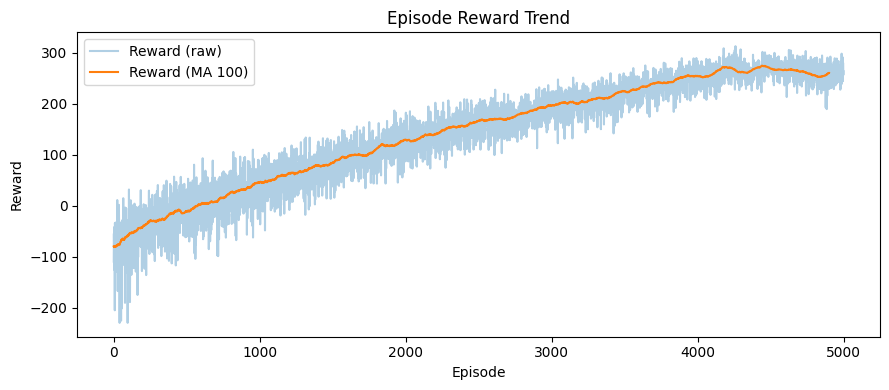

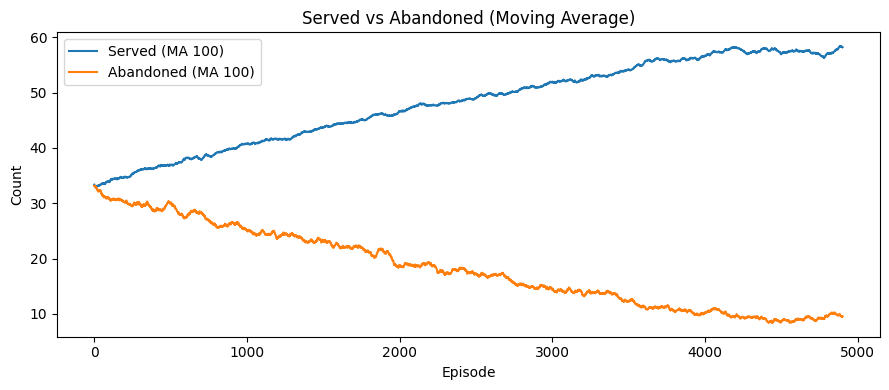

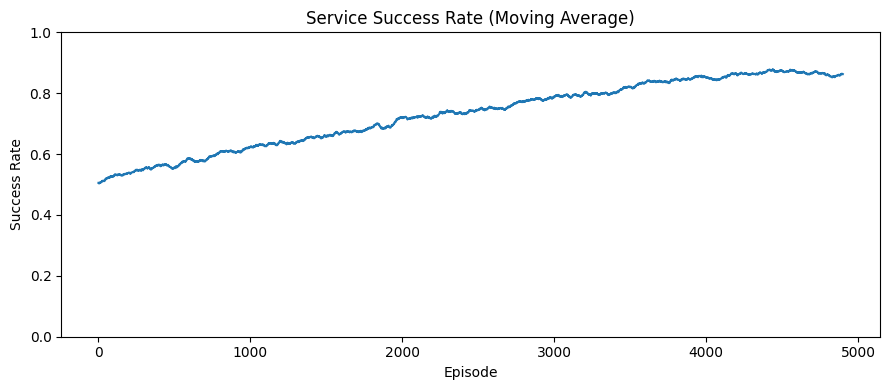

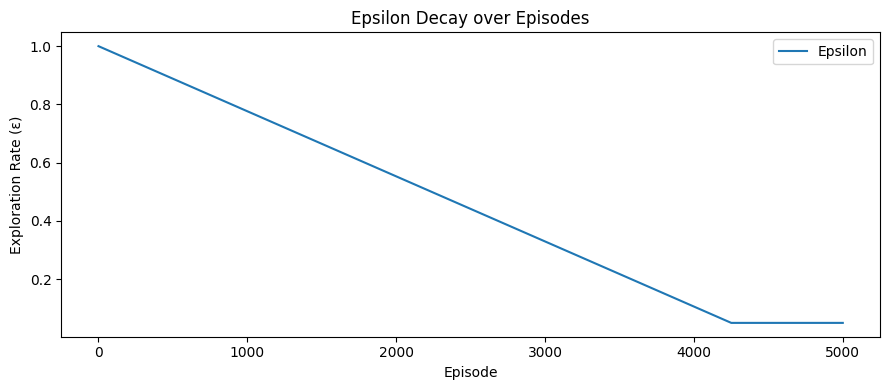

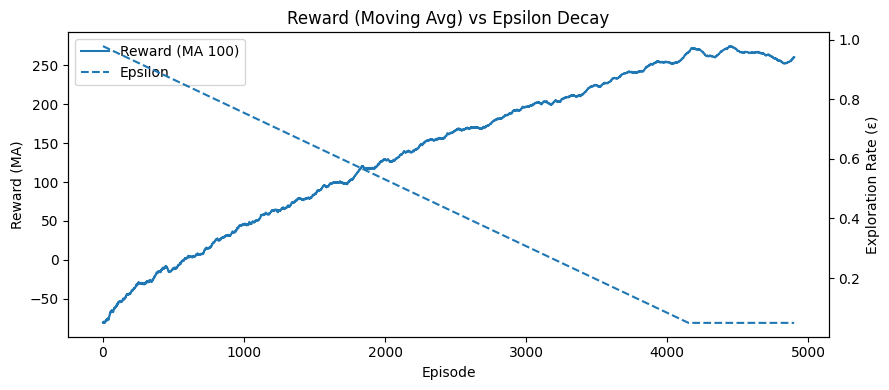

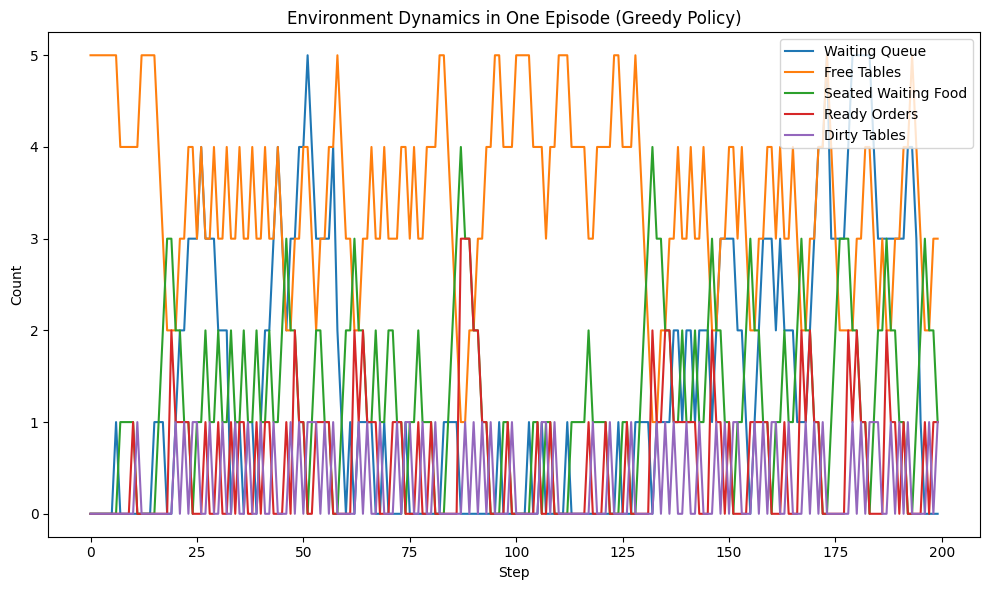

In [ ]:
# Visualization graphs printed for the project manager to understand clearly
plot_training(history, window=100)
visualize_episode(env, q)


Hello Boss,

This custom reinforcement learning model is created to simulate the operations of a restauraunt. This idea came across my group as I still work in the restaurant business as a sushi chef and a waiter. The goal of this model is to represent a real-world process where the agent has to manage orders, tables, and customers. The goal for this agent is to properly maximize the restauraunts performance. This is done by promptly serving as many customers as it can, while also minimizing the wait times, table clutter, and customers that abandon the que. The environment was customly created to mimic a real business instead of a grid like the FrozenLake problem. This allows the agent to learn how to prioritize tasks and decision making based on the environment.

As stated above, the environment is based on a real-world business where the agents will have to deal with 5 variable states. This includes number of customers waiting to be seated (waiting_que), number of available tables (free_tables), customers that are seated waiting for food (seated_waiting_food), food that is ready to serve (ready_orders), and tables that need cleaning (dirty_tables). Each episode will also simulate a full working shift as a waiter that needs to properly manage their tasks. Actions that the agent can take is being idle, seating/taking orders, serving ready orders, and cleaning the tables. Here the agent will learn how to balance their task based on rewards given to them. The rewards will be given if the customer is successfully served and if the agent cleans the table to keep proper flow of the business. Penalties will be issued if the customers abandon the restaurant due to long ques or from the agent being idle.

The episode will flow in order as a real-world business. The first thing that will happen is the customer arriving to the restauraunt. After this, the agent will decide on one of the following actions explained above. This can be the agent standing idle not serving, or properly seating the customer. Once the order is placed, the kitchen will start the timer for cooking and depending on how long it took the agent to take the order, the customers will be allowed to abandond due to long waits. Lastly, rewards or penalties will be given based on how well the agent took care of the customers.

This model was completed by the understanding the uses of the reinforcement learning model and trying to apply that into a concept which I was familiar with. The reinforcement learning algorithm is a model where it learns how to solve a problem by itself with minimal human intervention. At most the user is able to create a custom environment, and set the rewards and penalties for the agent. This will use a q-table to train the model to understand what actions receieve rewards or penalties. An example to understand this is that the q-table will serve as a memory holder for the agent to learn the most optimized policy to achieve its goal. The q-table will be constantly updated at each step. Once it is trained, the agents learned policy will be tested to understand how well the model was trained on the environment without an updating q-table. This model in particular was tested to have an average of 273.49 rewards, served approximately around 58.25 people, and customers abandonded  9.75 per episode.


